<a href="https://colab.research.google.com/github/afiaka87/clip-guided-diffusion/blob/main/cgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Guided Diffusion 

Known Issues:
- generations are currently noisier than they should be. Use the [original](
https://colab.research.google.com/drive/1QBsaDAZv8np29FPbvjffbE1eytoJcsgA
) notebook for now:



**From [RiversHaveWings](https://twitter.com/RiversHaveWing)**

Generate vibrant and detailed images using only text.
- Originally by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). 
- Python repository and additions assembled by Clay Mullis (https://github.com/afiaka87)

**[Read Me](https://github.com/afiaka87/clip-guided-diffusion)**

In [1]:
#@title Licensed under the MIT License

# Copyright (c) 2021 Clay Mullis

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
#@title Grab code and install requirements
# colab only
%cd /content
!git clone 'https://github.com/afiaka87/clip-guided-diffusion'
!git clone 'https://github.com/afiaka87/guided-diffusion'
%pip install -r /content/clip-guided-diffusion/requirements.txt 
%pip install -e guided-diffusion

In [20]:
#@title Config
#@markdown Detailed usage instructions are at the bottom of the notebook.


#@markdown Text Prompts
prompt = "humongous refrigerator" #@param{type: "string"}
prompt_min = "" #@param{type: "string"}
min_weight = 0.1

#@markdown CLIP/Diffusion
image_size = "128"  #@param ["64", "128", "256", "512"]
image_size = int(image_size)

unconditional = False #@param{type: "boolean"}
clip_model_name = "ViT-B/32" #@param ["RN50", "ViT-B/32", "ViT-B/16", "RN50x4", "RN50x16"]

#@markdown Initial image (url or path, set to "" to disable)
init_image = "" #@param{type: "string"}
skip_timesteps = 0 #@param{type: "number"}
if len(init_image) > 0 and skip_timesteps == 0:
    print("Overriding skip_timesteps to 500 because init_image is set but skip_timesteps is 0. You may want to override this manually.")
    skip_timesteps = 500
if len(init_image) == 0:
    if skip_timesteps > 0:
        print("Overriding skip_timesteps to 0 because you dont have an init image set.")
        skip_timesteps = 0
    init_image = None

#@markdown Knobs
num_cutouts = 64 #@param{type: "number"}
timestep_respacing = "1000" #@param ["25", "50", "100", "250", "500", "1000", "ddim25", "ddim50", "ddim100", "ddim250", "ddim500", "ddim1000"]
clip_guidance_scale = 1000 #@param{type: "number"}
tv_scale = 100 #@param{type: "number"}
cutout_power = 0.5 #@param {type: "number"}
cutout_power = float(cutout_power)

#@markdown Use CLIP to find ImageNet classes (consider lowering clip guidance scale to avoid artifacts/noise)
class_score = False #@param{type: "boolean"}
top_n = 1000

#@markdown Output
save_frequency = 1 #@param{type: "number"}

# probably don't touch
batch_size = 1
diffusion_steps = 1000 # best to leave this alone.
output_dir = "outputs"
seed = 0
random_affine = False
random_motion_blur = False
random_horizontal_flip = False
augs = []
import kornia.augmentation as kaugs
if random_affine: augs.append(kaugs.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1))
if random_motion_blur: augs.append(kaugs.RandomMotionBlur(kernel_size=(3, 5), angle=15, direction=0.5))
if random_horizontal_flip: augs.append(kaugs.RandomHorizontalFlip(p=0.5))


# Run

In [21]:
from tqdm.autonotebook import tqdm
progress_bar = tqdm(total=int(timestep_respacing)-skip_timesteps, desc="Timesteps")

Timesteps:   0%|          | 0/1000 [00:00<?, ?it/s]

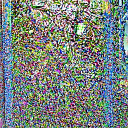

Saved 1000 total images from guided diffusion to outputs.
You may need to restart the runtime to generate another image.


In [22]:
#@title Run
from pathlib import Path
from IPython import display as ipy_display

import sys
import os
import torch as th
sys.path.append("/content/guided-diffusion")
sys.path.append("/content/clip-guided-diffusion" if "clip-guided-diffusion" not in os.getcwd() else ".")
from cgd import util as cgd_util
from cgd.cgd import clip_guided_diffusion

clear_scrollback = True # @param {type:"boolean"}
display_width = 256 if image_size < 512 else 512

# convert Path arg to Path object

prefix_path = Path('./outputs')
prefix_path.mkdir(exist_ok=True)

# Assertions
assert prefix_path.is_dir(), f"--prefix,-dir {prefix_path} is a file, not a directory. Please provide a directory."
assert 0 < save_frequency <= int(timestep_respacing.replace('ddim', '')), f"save_frequency must be greater than 0 and less than {timestep_respacing}"

# Load init image.
if init_image is not None:
    if init_image.startswith("http"):
        !wget --continue $init_image -O init_image.jpg
    else:
        !cp -n -v $init_image init_image.jpg
    init_image = "init_image.jpg"

# Initialize clip guided diffusion generator

_class_cond = not unconditional
cgd_samples, _, diffusion = clip_guided_diffusion(
    prompt=prompt, 
    prompt_min=prompt_min, 
    min_weight=min_weight, 
    batch_size=batch_size, 
    tv_scale=tv_scale, top_n=top_n,
    image_size=image_size, class_cond=_class_cond, 
    clip_guidance_scale=clip_guidance_scale, cutout_power=cutout_power,
    num_cutouts=num_cutouts, timestep_respacing=timestep_respacing, 
    custom_device='cuda' if th.cuda.is_available() else 'cpu', seed=seed,
    diffusion_steps=diffusion_steps, 
    skip_timesteps=skip_timesteps, init_image=init_image,
    clip_model_name=clip_model_name,
    class_score=class_score,
    randomize_class=_class_cond, 
    augs=augs
)
# Do the run
all_images = []
try:
    current_timestep = diffusion.num_timesteps - 1
    for step, sample in enumerate(cgd_samples):
        current_timestep -= 1
        progress_bar.update()
        if step % save_frequency == 0 or current_timestep == -1:
            if clear_scrollback:
                ipy_display.clear_output(wait=True)
            for j, image in enumerate(sample["pred_xstart"]):
                image_path = cgd_util.log_image(image, str(prefix_path), prompt, prompt_min, step, j)
                ipy_display.display(ipy_display.Image(image_path, width=display_width, height=display_width))
                all_images.append(image_path)
except RuntimeError as runtime_ex:
    if "CUDA out of memory" in str(runtime_ex):
        print(f"CUDA OOM error occurred.")
        print(f"Try lowering --image_size/-size, --batch_size/-bs, --num_cutouts/-cutn")
        print(f"--clip_model/-clip (currently {clip_model_name}) can have a large impact on VRAM usage.")
        print(f"'RN50' will use the least VRAM. 'ViT-B/32' the second least and is good for its memory/runtime constraints.")
        # Seems to be a memory leak specific to ipython/jupyter/pytorch
        # If you're rerunning this cell, you may need to restart the runtime.
    else:
        raise runtime_ex

progress_bar.close()
print(f"Saved {len(all_images)} total images from guided diffusion to {output_dir}.")
print(f'You may need to restart the runtime to generate another image.')

# Usage
- `prompt` - the text to be used for generating the image.
- `prompt_min` - (optional) - text you would like to penalize during generation.
- `clip_guidance_scale` - CLIP based loss scale. **Requires experimentation to find the best value. 100-500 seems to work well with class_search, 500-2000 for more abstract prompts.**
- `tv_scale` - Denoising loss scale. **Requires experimentation to find the best value. 0-250 seems to work well.**
- `class_score` Rank classes with CLIP instead of uniform random selection
- `top_n` max classes to rank.
- `timestep_respacing` - Number of timesteps to visit out of total `diffusion_steps`.
- `timestep_respacing` must be one of `["25", "50", "100", "250", "500", "1000", "ddim25", "ddim50", "ddim100", "ddim250", "ddim500", "ddim1000"]`
    - Smaller values are much faster but less accurate.
    - Larger values are very accurate but take much longer.
- `init_image` - Sample image for `skip_timsteps` before guiding with CLIP.
- `skip_timesteps` should be less than `timestep_respacing` and `diffusion_steps`
- `num_cutouts` can be increased to increase the number of random cutouts CLIP sees. Higher is more accurate but takes longer.
- `cutout_power` can be decreased to 0.5 with sufficiently high num_cutouts.
- `num_cutouts` makes much less of a difference with guided diffusion. 8 seems to be a good minimum and beyond 64 seems to have diminishing returns.
- disabling `class_cond` will also disable class randomization/clip scoring
- I have not experimented with transforms much; these are merely here to showcase how to use them.**

VRAM/Runtime for `clip_model=ViT-B/32`, `cutn=32`, `timestep_respacing=250`, GPU: RTX 2070 Super (8GB)
- 64x64 - **3402 MB, 46.4s**
- 128x128 - **3524 MB, 67.9s**
- 256x256 - **7149 MB, 159.1s**
- 512x512 - **Untested (requires more than 8 GB of VRAM)**